In [83]:
import os 
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib import patches

In [84]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [85]:
def from_coco_to_corner(boxes):
    print(boxes)
    return tf.stack([
        boxes[:,0], 
        boxes[:,2], 
        boxes[:,1], 
        boxes[:,3]
    ], axis=-1)
    


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """

    return tf.stack(
        [(boxes[:,0] + boxes[:, 2]) / 2,
        (boxes[:, 1] + boxes[:, 3]) / 2,
        boxes[:, 2] - boxes[:,0], 
        boxes[:, 3] - boxes[:, 1]], 
        axis=-1
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


In [86]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
    ):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [202]:
def visualize_test(): 
    data = train_dataset.take(1)

    data = list(data.as_numpy_iterator())[0]
    image = data["image"] 
    height, width = image.shape[:2]
    bbox = swap_xy(data["objects"]["bbox"])
    print(bbox)
    # scaling the bbox to the image 
    print(bbox)
    bbox = tf.stack([bbox[:,0] * width, bbox[:,1] * height, (bbox[:,2] - bbox[:, 0]) * width, (bbox[:,3] - bbox[:,1]) * height], axis=-1)
    print(bbox)
    
    
    
    # anchor 
    anchor = Anchor()
    image_anchors = anchor.get_anchors(width,height)[0]
    print(len(image_anchors))
    print(image_anchors)
    fig, ax = plt.subplots(figsize=(12,10))
    for idx,anc in enumerate(image_anchors): 
        rect = patches.Rectangle((anc[0], anc[1]), anc[2], anc[3], linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(rect)    
        if idx > 100:
            break
    
    
    for box in bbox: 
        
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=4, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.imshow(image) 
    plt.show()
    
    

tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[ 86.17     251.24     129.78     204.53    ]
 [331.44     234.27     238.88     137.39998 ]
 [236.62001  150.84      47.019997 150.40001 ]], shape=(3, 4), dtype=float32)
level 3
tf.Tensor(72.0, shape=(), dtype=float32) tf.Tensor(52.0, shape=(), dtype=float32)
(72, 52, 9, 2)
level 4
tf.Tensor(40.0, shape=(), dtype=float32) tf.Tensor(29.0, shape=(), dtype=float32)
(40, 29, 9, 2)
level 5
tf.Tensor(26.0, shape=(), dtype=float32) tf.Tensor(19.0, shape=(), dtype=float32)
(26, 19, 9, 2)
level 6
tf.Tensor(18.0, shape=(), dtype=float32) tf.Tensor(13.0, shape=(), dtype=float32)
(18, 13, 9, 2)
level 7
tf.Tensor(14.0, shape=(

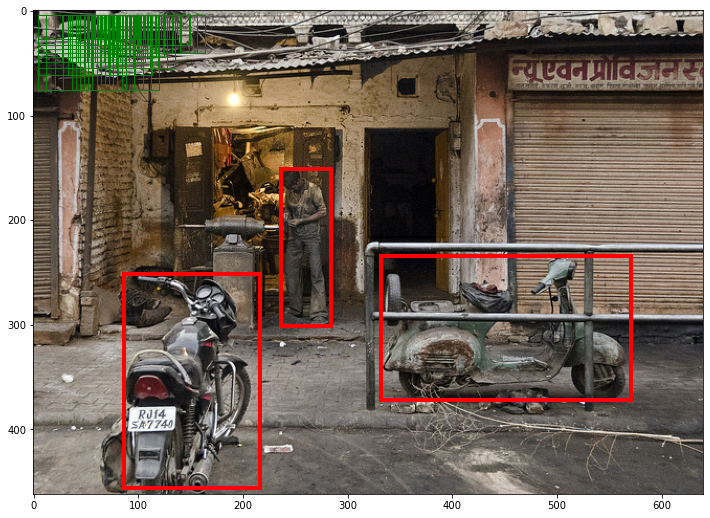

In [203]:
visualize_test()

In [187]:
class Anchor: 
    def __init__(self): 
            self.aspect_ratios = [0.5, 1, 2] 
            self.scales = [2 ** i for i in [0, 1/3, 2/3]]
            self.num_anchors = len(self.aspect_ratios) * len(self.scales)

            # convolution stride | level of the pyramid 
            self.strides = [2**i for i in range(3,8)]
            self.areas = [x**2 for x in [32, 64, 128, 256, 512]]
            self.dims = self._anchor_dims()
            
    def _anchor_dims(self):
        all_anchor_dims = [] 
        
        # for each stride
        for area in self.areas: 
            anchor_dims = []
            # get 9 anchor boxes
            for ratio in self.aspect_ratios:
                a_h = tf.math.sqrt(area/ratio)
                a_w = area/a_h
                stack = tf.reshape(tf.stack([a_h, a_w], axis=-1), [1,1,2]) 
                for scale in self.scales: 
                    anchor_dims.append(scale * stack)
            all_anchor_dims.append(tf.stack(anchor_dims, axis=-2))
        return all_anchor_dims
    
    
    def _get_anchors(self, feature_height, feature_width, level): 
        print("level", level)
        print(feature_height, feature_width)
        rx = tf.range(feature_width, dtype="float32") + 0.5
        ry = tf.range(feature_height, dtype="float32") + 0.5 
        # meshgrids => generate 1) x coords 2) y coorrds 
        # meshgrids + stack => stack x and y cords on the depth side
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self.strides[level - 3]    
        
        # CHELOU START
        centers = tf.expand_dims(centers, 2)
        # repeat centers for each anchor box 
        centers = tf.tile(centers, [1, 1, self.num_anchors, 1])
        print(centers.shape)
        dims = tf.tile(self.dims[level - 3], [feature_height, feature_width, 1, 1]) # (1,1,9,2)
        # rep
        # CHELOU END
        
        anchors = tf.concat([centers, dims], axis=-1)
        anchors = tf.reshape(
            anchors, [feature_height * feature_width * self.num_anchors, 4]
        )
        
        return anchors
    
    
    def get_anchors(self, image_height, image_width): 
        
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height/i**2),
                tf.math.ceil(image_width/i**2), 
                i
            )
            for i in range(3,8)
        ]
        
        return anchors
        

        

In [168]:
anchor = Anchor()
anchor.get_anchors(100,100)

level 3
(12, 12, 9, 2)
level 4
(7, 7, 9, 2)
level 5
(4, 4, 9, 2)
level 6
(3, 3, 9, 2)
level 7
(3, 3, 9, 2)


[<tf.Tensor: shape=(1296, 4), dtype=float32, numpy=
 array([[ 4.      ,  4.      , 45.254833, 22.627417],
        [ 4.      ,  4.      , 57.017517, 28.508759],
        [ 4.      ,  4.      , 71.83757 , 35.918785],
        ...,
        [92.      , 92.      , 22.627417, 45.254833],
        [92.      , 92.      , 28.508759, 57.017517],
        [92.      , 92.      , 35.918785, 71.83757 ]], dtype=float32)>,
 <tf.Tensor: shape=(441, 4), dtype=float32, numpy=
 array([[  8.      ,   8.      ,  90.50967 ,  45.254833],
        [  8.      ,   8.      , 114.035034,  57.017517],
        [  8.      ,   8.      , 143.67514 ,  71.83757 ],
        ...,
        [104.      , 104.      ,  45.254833,  90.50967 ],
        [104.      , 104.      ,  57.017517, 114.035034],
        [104.      , 104.      ,  71.83757 , 143.67514 ]], dtype=float32)>,
 <tf.Tensor: shape=(144, 4), dtype=float32, numpy=
 array([[ 16.      ,  16.      , 181.01933 ,  90.50967 ],
        [ 16.      ,  16.      , 228.07007 , 114.03503